In [ ]:
import pandas as pd
import os

# Path to your data folder
data_folder = "data"

# Initialize lists for Premier League and Serie A datasets
premier_league_files = [f for f in os.listdir(data_folder) if f.startswith("E0") and f.endswith(".csv")]
serie_a_files = [f for f in os.listdir(data_folder) if f.startswith("I1") and f.endswith(".csv")]

# Function to load and process files
def load_and_combine(files, league_name):
    combined_df = pd.DataFrame()  # Initialize empty DataFrame
    for file in files:
        # Load the dataset
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path)

        # Extract season from the filename (e.g., 'E0_2023.csv' -> '2023')
        season = file.split("_")[1].split(".")[0]
        df["Season"] = season  # Add the season column
        df["League"] = league_name  # Add a column to identify the league

        # Combine into a single DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

# Load and combine datasets for both leagues
premier_league_data = load_and_combine(premier_league_files, "Premier League")
serie_a_data = load_and_combine(serie_a_files, "Serie A")

# Combine both leagues into a single DataFrame
all_data = pd.concat([premier_league_data, serie_a_data], ignore_index=True)

# Display the first few rows
print(all_data.head())

# Save the combined dataset to a new CSV file
all_data.to_csv("combined_league_data.csv", index=False)
print("Combined dataset saved as 'combined_league_data.csv'.")


In [ ]:
all_data

In [ ]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('combined_league_data.csv')

# Split data by league and season
serie_a_data = data[data['League'] == 'Serie A']
pl_data = data[data['League'] == 'Premier League']

display(serie_a_data.head())
display(pl_data.head())

<ipython-input-34-7fe2d961cee4>:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('combined_league_data.csv')


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA
3040,I1,24/08/2019,17:00,Parma,Juventus,0,1,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3041,I1,24/08/2019,19:45,Fiorentina,Napoli,3,4,A,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3042,I1,25/08/2019,17:00,Udinese,Milan,1,0,H,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3043,I1,25/08/2019,19:45,Cagliari,Brescia,0,1,A,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3044,I1,25/08/2019,19:45,Roma,Genoa,3,3,D,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
serie_a_data.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
       'LBH', 'LBD', 'LBA'],
      dtype='object', length=129)

---
# Hypothesis Testing: Does the Premier League Have a Home-Field Advantage?

### Hypotheses:
We are testing if the **Premier League (PL)** has a **significantly higher home-team advantage** compared to **Serie A**.

- **Null Hypothesis (H₀)**: There is no significant difference in home-team advantage between the Premier League and Serie A, or Serie A has a higher home-team advantage.  
  
  $ H_0: \mu_{PL} - \mu_{Serie A} \leq 0 $

- **Alternative Hypothesis (H₁)**: The Premier League has a **significantly higher home-team advantage** than Serie A.  
  
  $ H_1: \mu_{PL} - \mu_{Serie A} > 0 $

This is a **right-tailed test**, where we are testing if the **home win proportion** in the Premier League is **significantly greater** than that in Serie A.

---

### Test Setup:

- **Difference**: We calculate the difference between the **home-team win proportions** for Premier League and Serie A:  

  $ \text{Difference} = p_{PL} - p_{Serie A} $

- **Region of Practical Equivalence (ROPE)**:  
  We define a **ROPE** to assess if the difference falls within a range that would be considered practically equivalent:  
  **ROPE**: (-0.05, 0.05), meaning we are open to considering small differences as insignificant.

---

### Decision Criteria:

- **Reject H₀** if the **difference** is significantly greater than **0.05** (i.e., if the Premier League has a **significantly higher home win proportion** than Serie A).
- **Fail to Reject H₀** if the **difference** falls within the **ROPE** (-0.05, 0.05), indicating no practical difference.
  

In [ ]:
# Initialize results storage
seasons = serie_a_data['Season'].unique()
posterior_means_serie_a = []
posterior_means_pl = []
posterior_diffs = []
trace_samples_serie_a = []
trace_samples_pl = []

# Define function to extract home wins and total matches
def get_season_data(serie_a_season, pl_season):
    n_serie_a = serie_a_season.shape[0]  # Total matches
    wins_serie_a = (serie_a_season['FTR'] == 'H').sum()  # Home wins in Serie A
    n_pl = pl_season.shape[0]  # Total matches
    wins_pl = (pl_season['FTR'] == 'H').sum()  # Home wins in PL
    return n_serie_a, wins_serie_a, n_pl, wins_pl

# Define Bayesian model
def run_bayesian_model(n_serie_a, wins_serie_a, n_pl, wins_pl):
    with pm.Model() as model:
        # Priors for home win proportions
        p_serie_a = pm.Beta('p_serie_a', alpha=2, beta=2)
        p_pl = pm.Beta('p_pl', alpha=2, beta=2)

        # Binomial likelihood for both leagues
        home_wins_serie_a = pm.Binomial('home_wins_serie_a', n=n_serie_a, p=p_serie_a, observed=wins_serie_a)
        home_wins_pl = pm.Binomial('home_wins_pl', n=n_pl, p=p_pl, observed=wins_pl)

        # Sampling
        trace = pm.sample(2000, return_inferencedata=False)

    return trace

# Iterate over seasons
for season in seasons:
    # Filter data for the season
    serie_a_season = serie_a_data[serie_a_data['Season'] == season]
    pl_season = pl_data[pl_data['Season'] == season]

    # Get season-specific data
    n_serie_a, wins_serie_a, n_pl, wins_pl = get_season_data(serie_a_season, pl_season)

    # Run the Bayesian model
    trace = run_bayesian_model(n_serie_a, wins_serie_a, n_pl, wins_pl)

    # Extract posterior samples
    p_serie_a_samples = trace['p_serie_a']
    p_pl_samples = trace['p_pl']
    difference_samples = p_serie_a_samples - p_pl_samples

    # Store results
    posterior_means_serie_a.append(np.mean(p_serie_a_samples))
    posterior_means_pl.append(np.mean(p_pl_samples))
    posterior_diffs.append(np.mean(difference_samples))
    trace_samples_serie_a.append(p_serie_a_samples)
    trace_samples_pl.append(p_pl_samples)

# Create DataFrame with results
results = pd.DataFrame({
    'Season': seasons,
    'Serie_A_Mean': posterior_means_serie_a,
    'PL_Mean': posterior_means_pl,
    'Difference': posterior_diffs
})
results.sort_values(by='Season', inplace=True)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [ ]:
display(results)

,Season,Serie_A_Mean,PL_Mean,Difference
6,2016,0.483674,0.491643,-0.007969
7,2017,0.432519,0.455726,-0.023208
1,2018,0.437526,0.476918,-0.039392
0,2019,0.416856,0.453587,-0.036731
4,2020,0.408767,0.379848,0.028919
5,2021,0.390172,0.429621,-0.039449
3,2022,0.424328,0.484233,-0.059905
2,2023,0.419821,0.460619,-0.040799


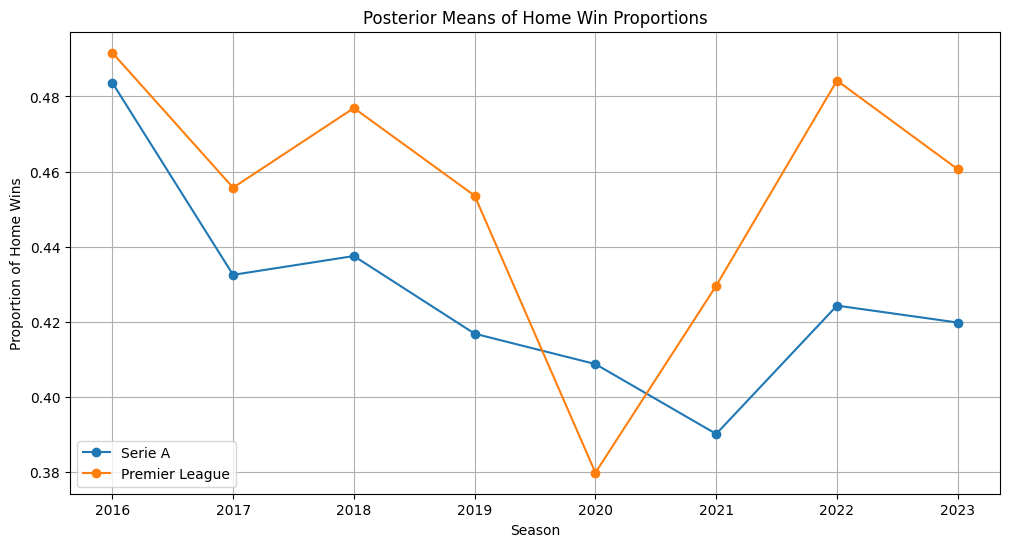

In [ ]:
# Plot posterior means for Serie A and PL
plt.figure(figsize=(12, 6))
plt.plot(results['Season'], results['Serie_A_Mean'], marker='o', label='Serie A')
plt.plot(results['Season'], results['PL_Mean'], marker='o', label='Premier League')
plt.title('Posterior Means of Home Win Proportions')
plt.xlabel('Season')
plt.ylabel('Proportion of Home Wins')
plt.legend()
plt.grid()
plt.show()

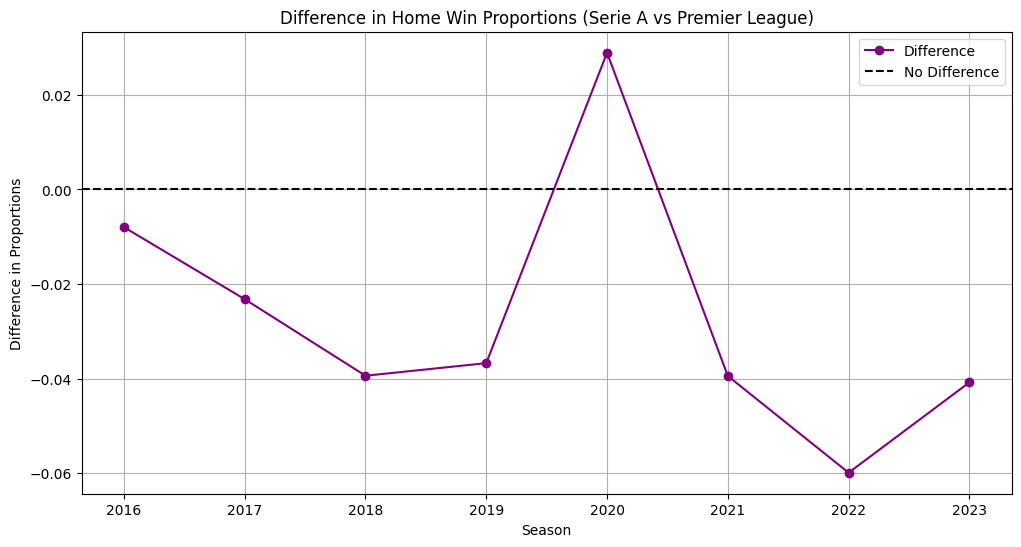

In [ ]:
# Plot the differences across seasons
plt.figure(figsize=(12, 6))
plt.plot(results['Season'], results['Difference'], marker='o', color='purple', label='Difference')
plt.axhline(0, color='black', linestyle='--', label='No Difference')
plt.title('Difference in Home Win Proportions (Serie A vs Premier League)')
plt.xlabel('Season')
plt.ylabel('Difference in Proportions')
plt.legend()
plt.grid()
plt.show()

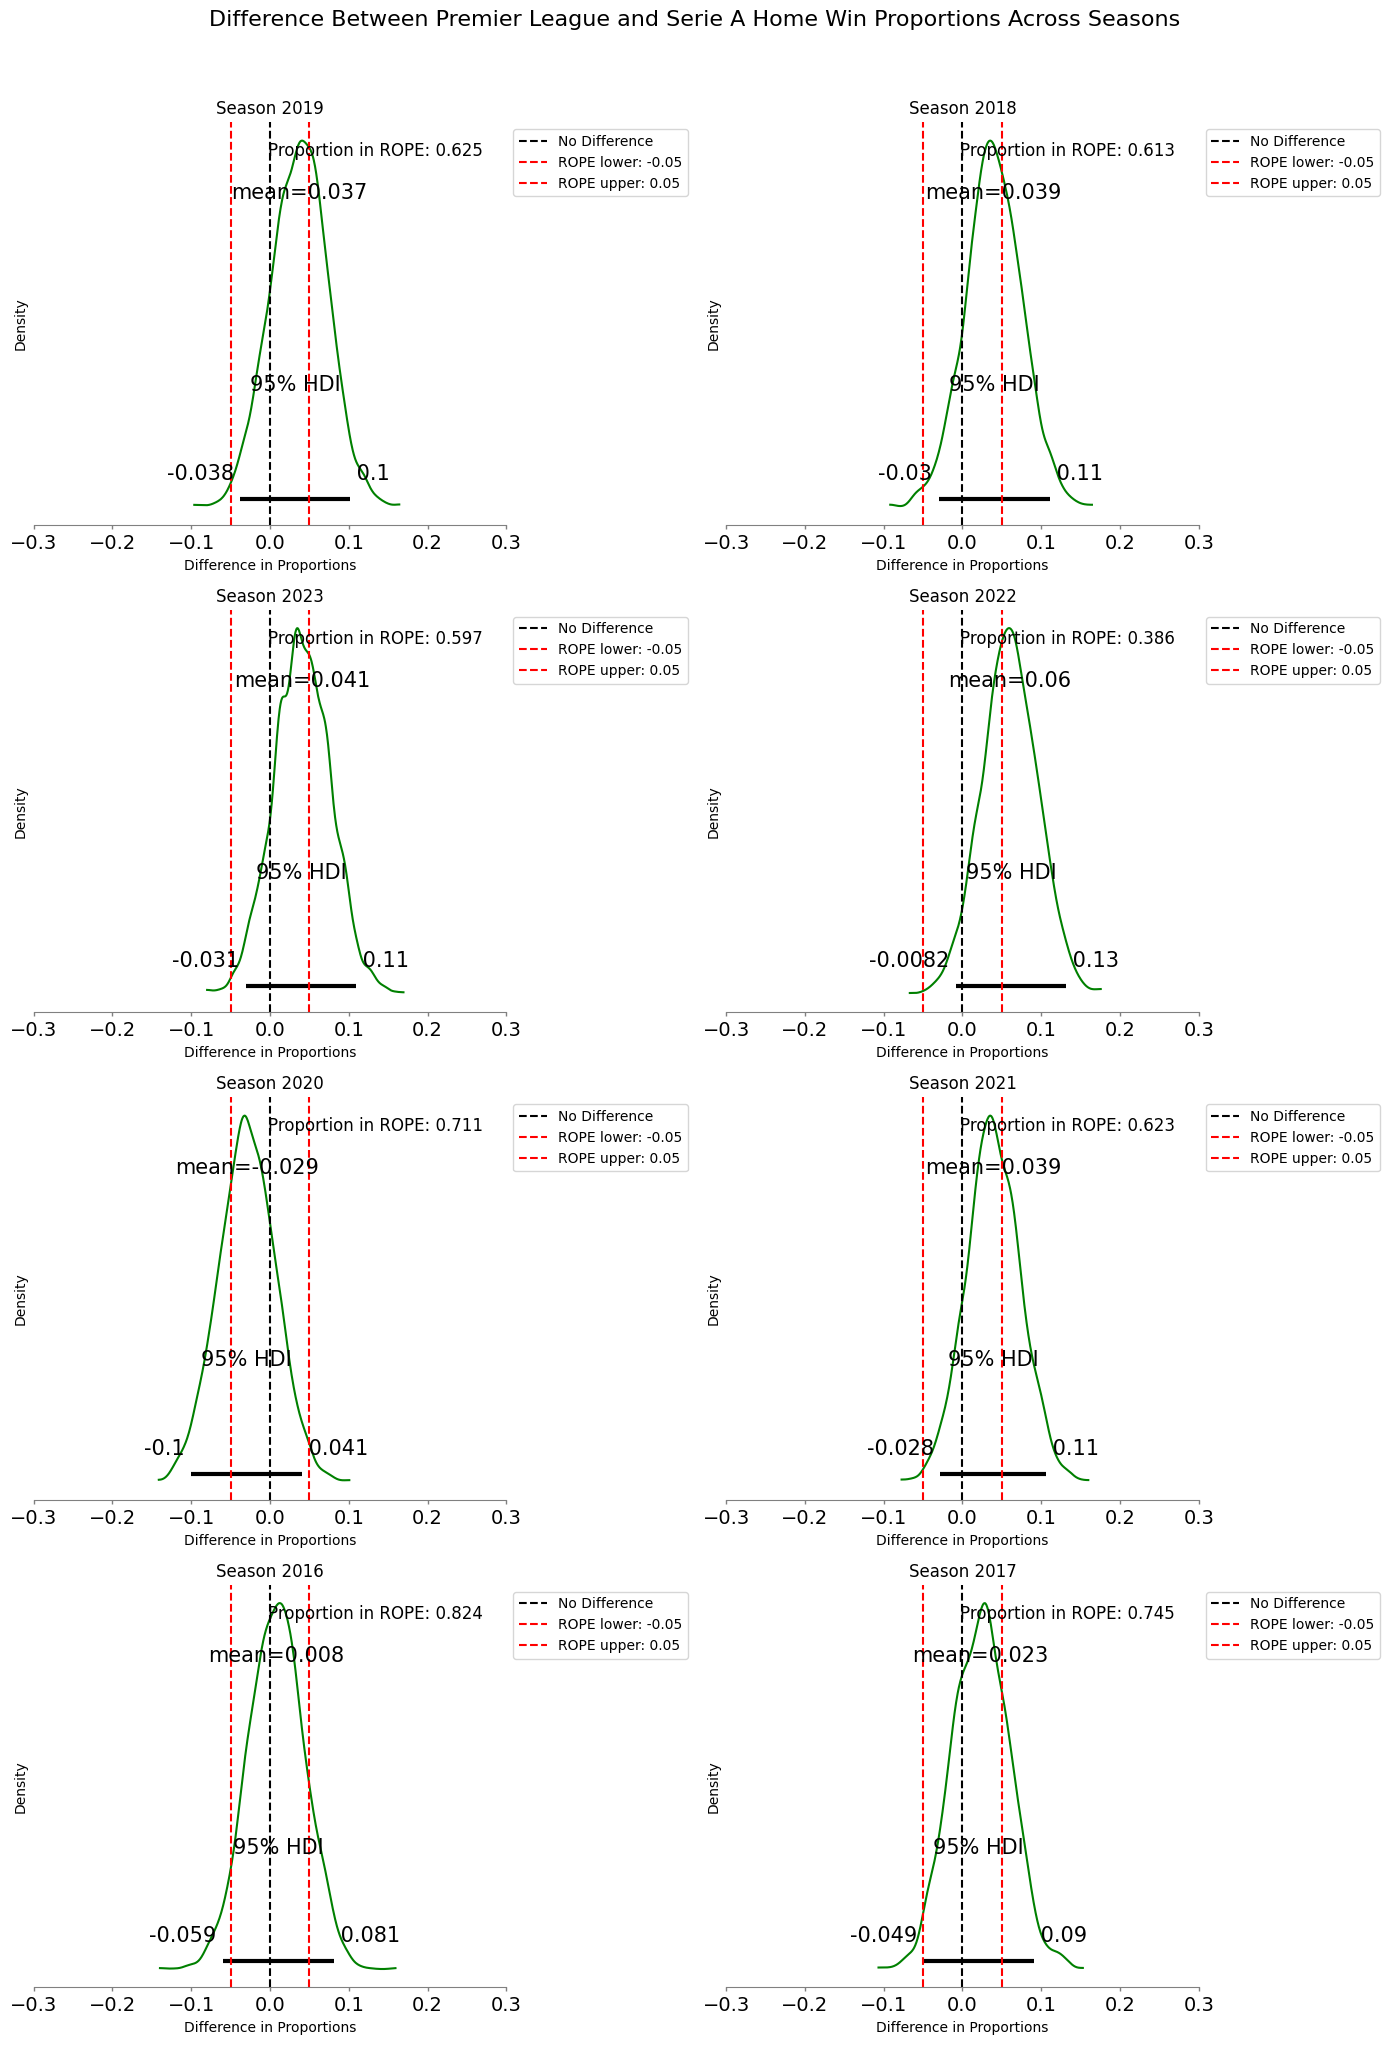

In [ ]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Initialize the rope limits
rope = (-0.05, 0.05)

pl_higher_probs = []
serie_a_higher_probs = []
all_difference_samples = []
in_rope_data = []

# Prepare the figure for plotting
plt.figure(figsize=(14, 20))  # Increase the figure size for larger plots

# Loop through each season and plot the posterior difference distributions
for idx, season in enumerate(seasons):
    difference_samples = trace_samples_pl[idx] - trace_samples_serie_a[idx]  # Corrected order for the PL vs Serie A difference
    all_difference_samples.extend(difference_samples)
    # Calculate the proportion of difference samples within the ROPE
    in_rope = np.sum((difference_samples >= rope[0]) & (difference_samples <= rope[1])) / len(difference_samples)
    in_rope_data.append(in_rope)
    # ArviZ: Plot posterior distribution of the difference
    plt.subplot(len(seasons) // 2 + len(seasons) % 2, 2, idx + 1)  # Two plots per row
    az.plot_posterior(difference_samples, hdi_prob=0.95, color='green', ax=plt.gca())

    # Add vertical lines for ROPE and no difference
    plt.axvline(0, color='black', linestyle='--', label='No Difference')
    plt.axvline(rope[0], color='red', linestyle='--', label=f'ROPE lower: {rope[0]}')
    plt.axvline(rope[1], color='red', linestyle='--', label=f'ROPE upper: {rope[1]}')

    # Move the text annotation outside the plot area
    plt.text(0.95, 0.95, f"Proportion in ROPE: {in_rope:.3f}", ha='right', va='top', transform=plt.gca().transAxes, fontsize=12)

    # Title and labels for individual plots (Year for each season)
    plt.title(f"Season {season}")
    plt.xlabel('Difference in Proportions')
    plt.ylabel('Density')
    plt.xlim(-0.3, 0.3)  # Set consistent x-axis limits

    # Adjust legend to not overlap with the plot area
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

    # Right-tailed testing (probability of PL > Serie A)
    pl_higher_prob = np.mean(difference_samples > 0.05)

    # Left-tailed testing (probability of Serie A > PL)
    serie_a_higher_prob = np.mean(difference_samples < -0.05)

    pl_higher_probs.append(pl_higher_prob)
    serie_a_higher_probs.append(serie_a_higher_prob)

# Add a single overarching title for all plots
plt.suptitle('Difference Between Premier League and Serie A Home Win Proportions Across Seasons', fontsize=16, y=1.02)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()



In [ ]:
print(pl_higher_probs)
print(serie_a_higher_probs)
print(in_rope_data)

[0.369, 0.379, 0.398, 0.61375, 0.01325, 0.3745, 0.12275, 0.23675]
[0.0065, 0.0085, 0.00475, 0.0005, 0.276, 0.003, 0.05375, 0.01875]
[0.6245, 0.6125, 0.59725, 0.38575, 0.71075, 0.6225, 0.8235, 0.7445]


In [ ]:
# Print out the results of the hypothesis test
for idx, season in enumerate(seasons):
    print(f"Season {season}:")

    print(f"  Probability of PL having a higher home win proportion: {pl_higher_probs[idx]:.3f}")
    print(f"  Probability of Serie A having a higher home win proportion: {serie_a_higher_probs[idx]:.3f}")
    print(f"  Proportion of difference samples in the ROPE: {in_rope_data[idx]:.3f}")
    print("\n")


Season 2019:
  Probability of PL having a higher home win proportion: 0.369
  Probability of Serie A having a higher home win proportion: 0.006
  Proportion of difference samples in the ROPE: 0.625


Season 2018:
  Probability of PL having a higher home win proportion: 0.379
  Probability of Serie A having a higher home win proportion: 0.009
  Proportion of difference samples in the ROPE: 0.613


Season 2023:
  Probability of PL having a higher home win proportion: 0.398
  Probability of Serie A having a higher home win proportion: 0.005
  Proportion of difference samples in the ROPE: 0.597


Season 2022:
  Probability of PL having a higher home win proportion: 0.614
  Probability of Serie A having a higher home win proportion: 0.001
  Proportion of difference samples in the ROPE: 0.386


Season 2020:
  Probability of PL having a higher home win proportion: 0.013
  Probability of Serie A having a higher home win proportion: 0.276
  Proportion of difference samples in the ROPE: 0.711




In [ ]:
# Calculate the overall probability of PL having a higher home win proportion (right-tailed)
overall_pl_higher_prob =  np.mean(pl_higher_probs)

# Calculate the proportion of difference samples across all seasons that fall within the ROPE
overall_in_rope = np.mean(in_rope_data)
# Print out the overall conclusion
print(f"Overall probability of PL having a higher home win proportion than Serie A: {overall_pl_higher_prob:.3f}")
print(f"Overall proportion of difference samples in the ROPE: {overall_in_rope:.3f}")

# Interpret the results
if overall_pl_higher_prob > 0.95:
    print("Conclusion: There is strong evidence to reject the null hypothesis (H₀), suggesting the Premier League has a significantly higher home-team advantage than Serie A.")
else:
    print("Conclusion: There is insufficient evidence to reject the null hypothesis (H₀), suggesting no significant difference or Serie A has a higher home-team advantage.")

Overall probability of PL having a higher home win proportion than Serie A: 0.313
Overall proportion of difference samples in the ROPE: 0.640
Conclusion: There is insufficient evidence to reject the null hypothesis (H₀), suggesting no significant difference or Serie A has a higher home-team advantage.


By applying Bayesian modeling with PyMC and analyzing the posterior distributions, we are able to assess:
The home win proportions for both Serie A and Premier League over multiple seasons.
The difference between these proportions, helping us evaluate if Serie A has a higher proportion of home wins than the Premier League.
The hypothesis testing using the ROPE, which allows us to determine if the differences are practically significant.
The probabilistic interpretation of the differences, such as the probability that Serie A has a higher home win proportion.
This approach ensures that your analysis takes full advantage of probabilistic programming, providing a more robust and data-driven conclusion.